### Описание проекта
Исследование датасета о продаже компьютерных игр в период 1976 - 2016 гг.<br><br>
Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. В датасете представлены данные до 2016 года. Представим, что сейчас декабрь 2016 г., и планируется кампания на 2017-й.

### Шаг 1. Изучение общей информации

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import statistics
from scipy.stats import levene

In [3]:
df = pd.read_csv('D:\\ds\\games.csv')
pd.set_option('display.max_columns', None)

In [4]:
def get_info(dataframe):
    display(dataframe.head(10))
    print()
    display(dataframe.info())
    print()
    print(f"Явных дубликатов: {dataframe.duplicated().sum()}")
    print()
    print('Пропусков в колонках:')
    for column in df.columns:
        print(f"{column}: {df[column].isna().sum()}")

def prep(dataframe):
    dataframe = dataframe.drop_duplicates()
    dataframe.columns = dataframe.columns.str.lower()
    return dataframe

In [5]:
get_info(df)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None


Явных дубликатов: 0

Пропусков в колонках:
Name: 2
Platform: 0
Year_of_Release: 269
Genre: 2
NA_sales: 0
EU_sales: 0
JP_sales: 0
Other_sales: 0
Critic_Score: 8578
User_Score: 6701
Rating: 6766


### Шаг 2. Предобработка данных

In [7]:
df = prep(df)

Явных дублей не обнаружено. Вижу два одиноких пропуска в колонках name и genre, пачку пропусков в Year_of_Release и множественные пропуски в столбцах с рейтингами. Пойдём по порядку. Поищу неявные дубли.

In [8]:
mask = df.duplicated(subset=['name', 'platform', 'year_of_release'], keep=False)
df[mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


Две строки с ошибкой выгрузки и одна задублированная. Избавлюсь от лишнего.

In [10]:
df.drop([659, 14244, 16230], inplace=True)

Дальше пропуски в дате релиза. В принципе, все эти даты известны и восстановить их точные значения можно, вопрос только в количестве. Можно было бы и руками обработать 269 пропусков, если бы требовалась критическая точность, но в данном случае, чтоб упростить себе задачу, прибегну к помощи нейросети. Выгружу в файл список названий и платформ, для которых требуется восстановить дату, и скормлю его нейросети. Немного поколдую с промтом и попрошу её не выдумывать значения там, где она не уверена, а проставить nan. Оставшиеся пропуски обработаю вручную, используя базу данных igromania.ru, в результате получу список дат.

In [11]:
year_list = [2004,2004,2008,2006,1978,2007,2005,2008,2006,2008,2010,2008,1998,1979,2008,1977,2009,2002,2002,2008,
             1999,1997,1977,2002,2011,2002,2010,2011,2008,2008,2011,2006,2003,2011,2008,2008,2005,2010,2010,2005,
             2011,2007,2002,2010,2008,2007,2005,2002,2001,2004,2001,1977,2006,2006,1977,2006,1977,2004,1978,2008,
             1976,2008,2007,2012,2002,2012,2003,2008,2008,1978,2007,2002,2003,2008,2014,2013,2010,1999,2002,2010,
             1980,2004,2002,1979,2000,2013,2002,2007,2006,2002,2002,2005,2002,2004,1995,2010,1978,2008,2008,2011,
             2005,2011,2016,2010,2010,2010,2002,2006,2002,2010,2011,2004,1989,1978,2002,2011,2009,2008,2010,2001,
             2013,2009,2011,2006,2008,2001,2008,2001,2006,2008,2010,2002,2002,2010,2001,2007,2011,1983,2001,2004,
             2010,2007,2000,2010,2006,1999,2008,2007,2008,2010,2011,2007,2003,2007,2007,2002,2005,2003,2006,2003,
             2011,2006,2007,2008,2011,2008,2011,2010,2009,2005,2009,2000,2003,2009,2011,2008,2009,2010,2008,2011,
             2009,2002,2010,2012,2013,2008,2008,2004,2003,2009,2001,2010,2009,2006,2006,2008,2004,2009,2012,2006,
             2010,2011,2003,2005,2011,2008,2011,2008,2009,2003,1999,2011,1979,2016,2008,2016,2003,2008,2006,2010,
             2008,2004,2007,2012,2005,2009,2009,2005,2006,2014,2011,2003,2003,2006,2010,2003,2011,2006,2009,2008,
             2006,2005,2011,2009,2009,2003,2003,2008,2008,2006,2002,2009,2008,2008,2008,2006,2006,2003,1997,2015,
             2006,2009,2008,2008,2008,2002,2012,2008,2003]
             
print(len(year_list))
print(max(year_list))

269
2016


Контроль размера и значений показывает, что нейронка не наврала, ну или наврала не слишком сильно. Далее, при построении визуализаций, дополнительно проконтролирую верность замены. Подставлю значения из списка в датафрейм.

In [12]:
mask = df['year_of_release'].isnull()
df.loc[mask, 'year_of_release'] = year_list
print(df['year_of_release'].isnull().sum())

0


Заполнить пропуски в столбцах с рейтингом не представляется возможным. Не известно откуда взята шкала оценок пользователей и критиков. Рейтинг ESRB можно было бы попробовать восстановить, но 6766 значений пока что многовато даже для нейросети. Придётся оставить как есть. Поищу ещё какие-нибудь неявные аномалии.

In [13]:
counts = df['name'].value_counts()
counts

Need for Speed: Most Wanted           12
FIFA 14                                9
Ratatouille                            9
LEGO Marvel Super Heroes               9
Madden NFL 07                          9
                                      ..
The Legend of Zelda: Majora's Mask     1
Diabolik Lovers: Vandead Carnival      1
Winning Post 4                         1
Tokyo Xtreme Racer DRIFT               1
Super Sentai Battle: Ranger Cross      1
Name: name, Length: 11559, dtype: int64

In [14]:
df[df['name'] == 'Need for Speed: Most Wanted']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6410,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


Дважды повторяется строка с X360 и PC. Может это и какое-то переиздание, но ничто на то не указывает, поэтому удалю строки от 2012 года.

In [15]:
df.drop([1190, 11715], inplace=True)

Проверил несколько других тайтлов, ничего подозрительного больше не обнаружил. Не буду нагромождать работу таблицами с проверкой.

In [16]:
df['genre'].value_counts()

Action          3369
Sports          2347
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1247
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

In [17]:
df['platform'].value_counts()

PS2     2161
DS      2151
PS3     1330
Wii     1320
X360    1261
PSP     1209
PS      1197
PC       973
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

In [18]:
df['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.9       2
0.7       2
1.1       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

В user_score находится строковое значение tbd означающее, что рейтинг не определён. Заменю его на nan, чтоб можно было привести данные к числовому типу.

In [20]:
df['user_score'] = (df['user_score'].replace('tbd', np.nan)).astype('float64')
df['rating'].value_counts()

E       3989
T       2959
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

Все указанные значения можно найти в классификаторе ESRB.

In [21]:
df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score']].describe()

,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,16710.000000,16710.000000,16710.000000,16710.000000,8134.000000,7587.000000
mean,0.263312,0.145020,0.077638,0.047341,68.962626,7.124898
std,0.813628,0.503378,0.308897,0.186756,13.938248,1.500021
min,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000
50%,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000
75%,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000
max,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000


Отрицательных значений нет - уже неплохо. Предельные зачения выглядят похожими на правду. Далее создам новый столбец, в котором просуммирую продажи по всем регионам.

In [22]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

Изменю тип данных в столбце с датой и на этом заканчиваю предобработку.

In [24]:
df['year_of_release'] = df['year_of_release'].astype('int64')
print(df['year_of_release'].min())
print(df['year_of_release'].max())

1976
2016


### Шаг 3. Исследовательский анализ данных

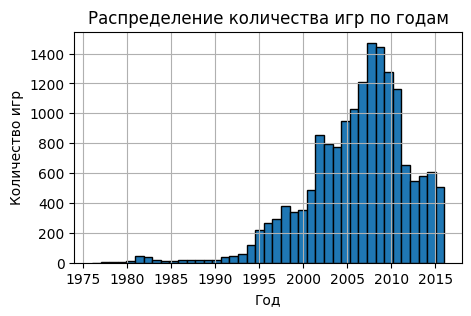

In [27]:
plt.figure(figsize=(5, 3))
df['year_of_release'].hist(bins=41, edgecolor='black')
plt.title(f'Распределение количества игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()

Период 1975 - 2000 представляет разве что историческую ценность. Период 2000 - 2010 может быть интересен для изучения общих характеристик рынка, т.к. именно в этом периоде распределена большая часть выпускаемых игр. Для планирования кампании на 2017 год наиболее важным будет период за последние 2-4 года.

Посмотрю, как менялись продажи и популярность по платформам. Выберу наиболее популярные платформы и построю распределение по годам. 

In [28]:
df['platform'].value_counts()

PS2     2161
DS      2151
PS3     1330
Wii     1320
X360    1261
PSP     1209
PS      1197
PC       973
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

Опираясь на количество представленных тайтлов и общую актуальность, выбираю 16 первых платформ для первоначального исследования.

In [29]:
top16 = df['platform'].value_counts().head(16)

In [34]:
def histogram(platform, bins=22, range=(1995, 2016)):
    data_slice = df.query('platform == @platform')
    plt.figure(figsize=(6, 2))
    data_slice['year_of_release'].hist(bins=bins, range=range, edgecolor='black')
    plt.title(f'Распределение количества игр на платформе {platform} по годам')
    plt.xlabel('Год выпуска')
    plt.ylabel('Количество игр')
    plt.show()

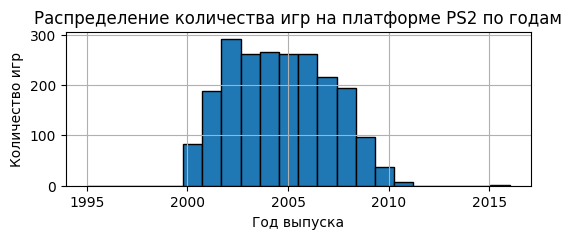

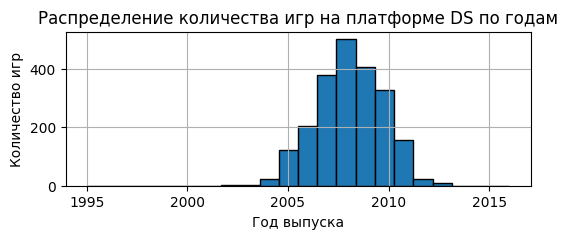

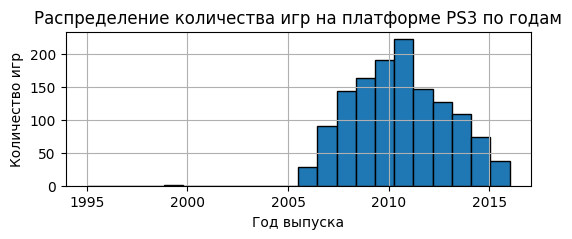

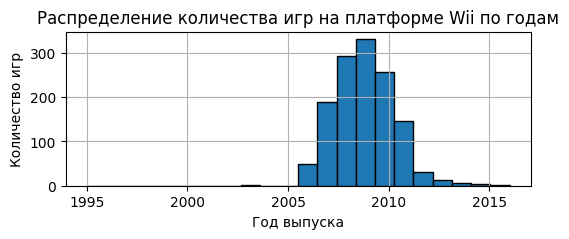

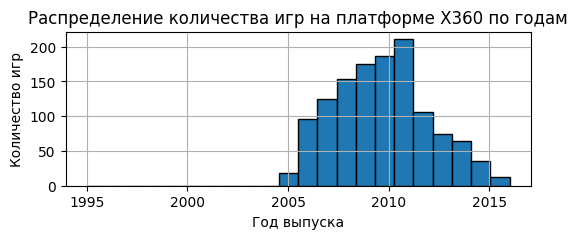

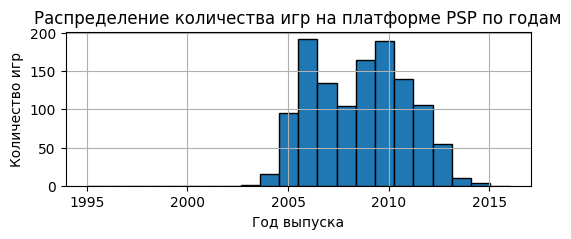

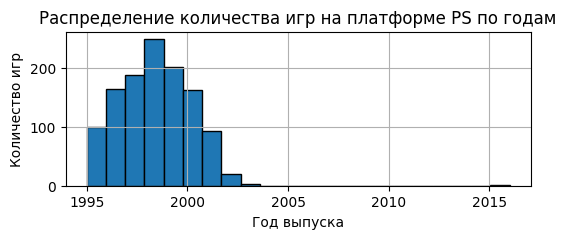

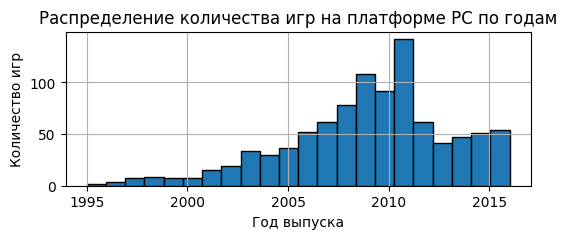

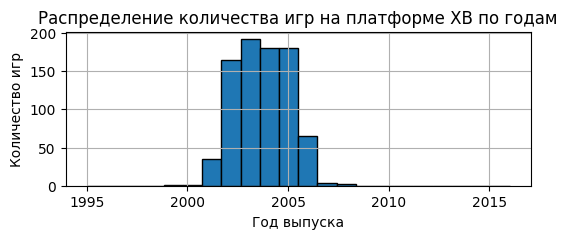

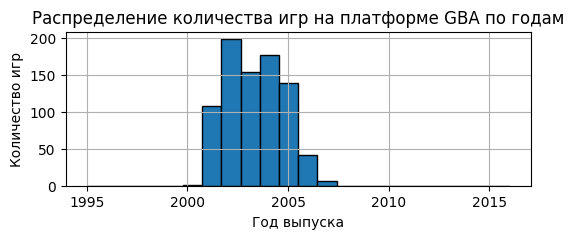

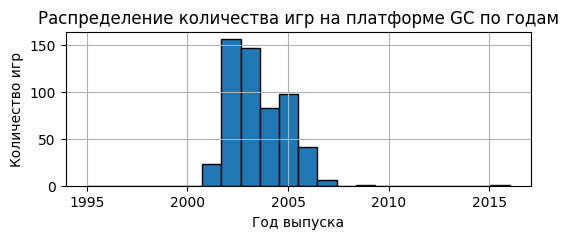

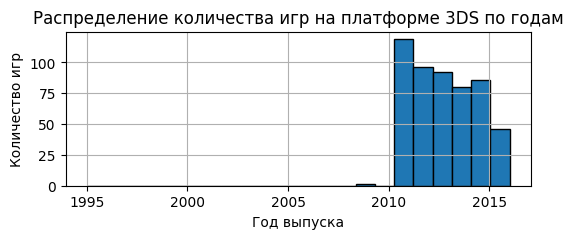

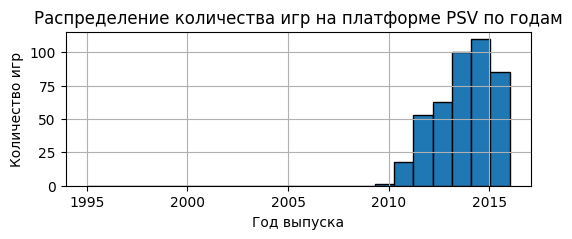

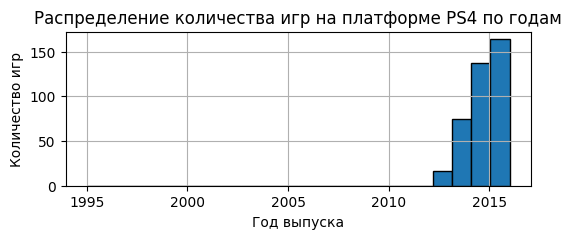

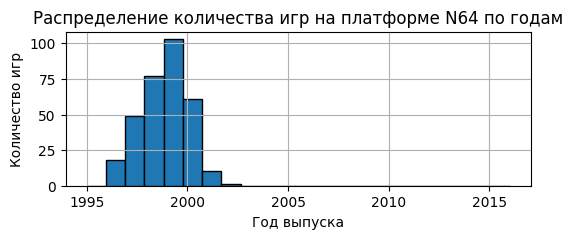

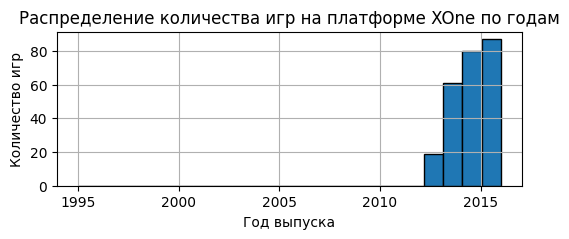

In [35]:
for platform in top16.index:
    histogram(platform)

In [40]:
def sales(platform):
    data_slice = df.query('platform == @platform')
    platform_sales = data_slice.groupby('year_of_release')['total_sales'].sum()
    plt.figure(figsize=(6, 2))
    plt.plot(platform_sales.index, platform_sales.values, marker='o', linestyle='-')
    plt.title(f'Продажи на платформе {platform} по годам')
    plt.xlabel('Год')
    plt.ylabel('Продажи (в млн. копий)')
    plt.xlim(1995, 2016)
    plt.ylim(0, 250)
    plt.xticks(np.arange(1995, 2017, step=5), rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

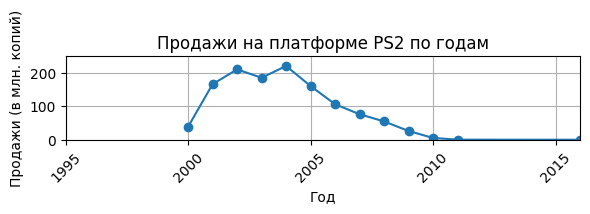

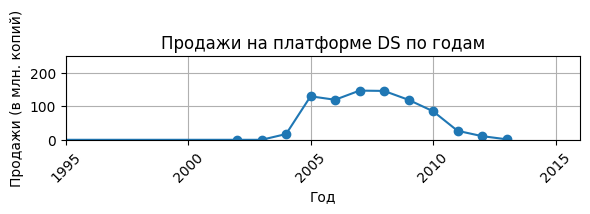

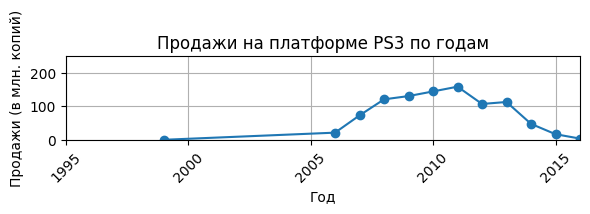

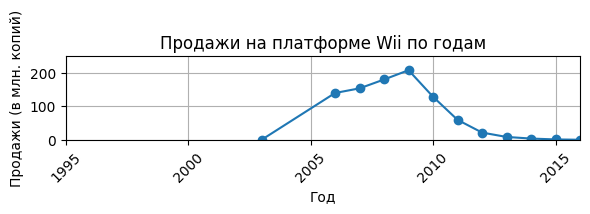

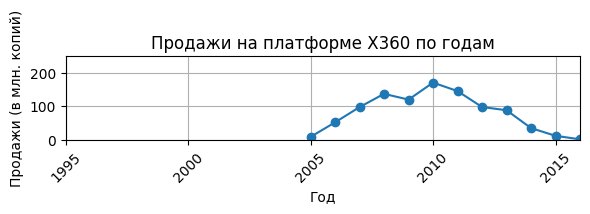

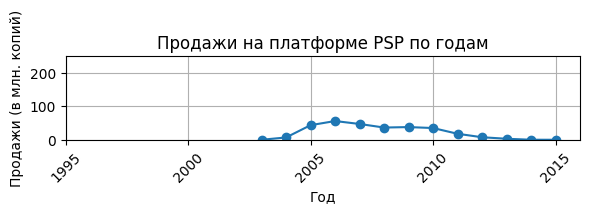

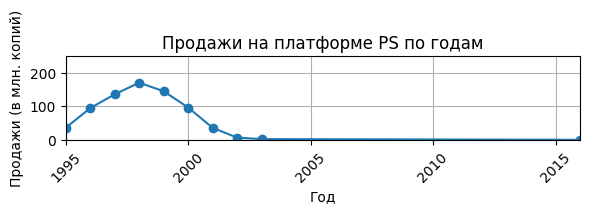

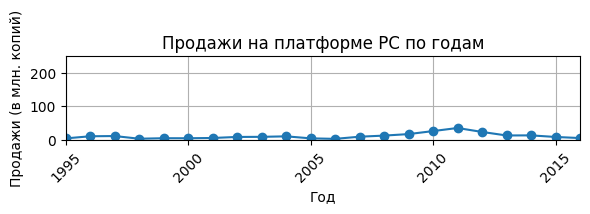

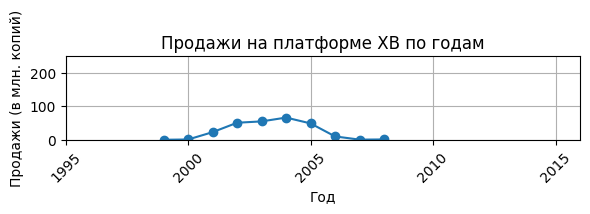

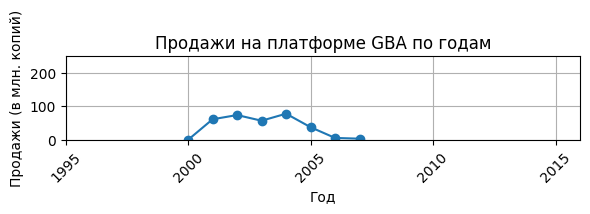

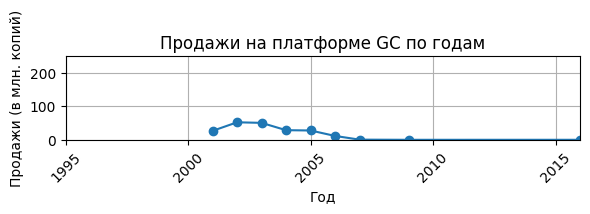

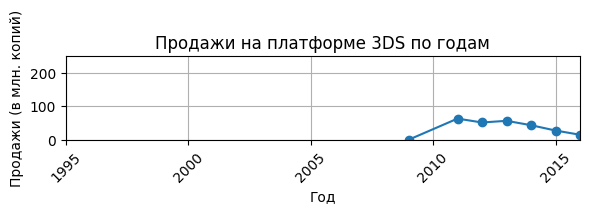

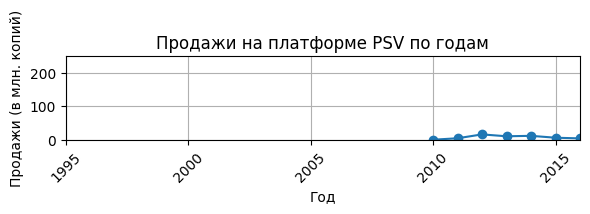

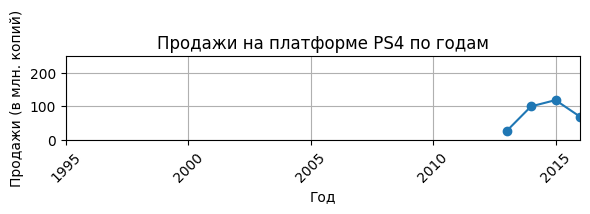

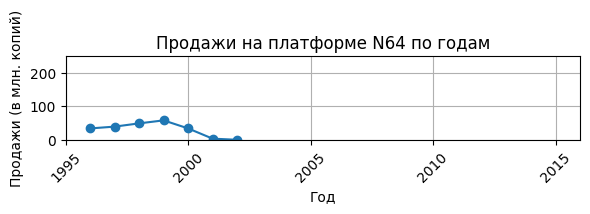

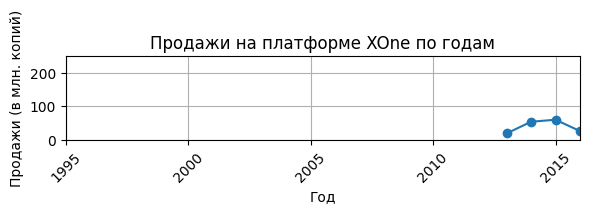

In [41]:
for platform in top16.index:
    sales(platform)

На визуализациях всплыло несколько значений там, где платформы ещё не существовало либо уже была прекращена её поддержка. Исключать из датасета сейчас эти строки не имеет смысла, так как в дальнейшем, при выборе актуального периода для анализа, они всё равно будут отброшены.

В целом по графикам видно, что меняются поколения игровых консолей, платформы приходят и уходят, а PC остаётся. Какие-то живут дольше, какие-то меньше. Можно выделить характерный срок набора и спада популярности, общей продолжительности жизни платформ. У PSP можно выделить несколько пиков на графике распределения количества игр. Связано это с тем, что в рамках этой платформы производитель выпускал несколько обновлений платформы, но в данной выборке они объединены. Также можно выделить платформу 3DS, которая не имеет характерного периода набора популярности, а сразу стартанула с пика продаж. Связать это можно с маркетинговой кампанией производителя перед выпуском консоли и высокой ожидаемостью у потребителя. Более подробный анализ в финальном выводе.<br><br>

Поставлена задача определить актуальный временной период для последующего исследования. Для этого буду смотреть на сформированные графики наиболее актуальных платформ. В такой динамично меняющейся индустрии, как компьютерные игры, не стоит брать слишком большой временной интервал - иначе обязательно захватим уже отжившие тренды. Беру диапазон с 2014 по 2016гг.

In [43]:
df = df.loc[df['year_of_release'] >= 2014]

Поставлена задача определить какие платформы лидируют по продажам и выбрать несколько потенциально прибыльных платформ.

In [44]:
(df[df['platform'].isin(top16.index)]
 .pivot_table(index='platform', values='total_sales', aggfunc='sum')
 .sort_values(by='total_sales', ascending=False)
)

,total_sales
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.60
PC,27.06
Wii,5.07
PSP,0.36
PS,0.04


В сводной таблице видно лидеров продаж за период 2014-2016. Однако, для определения потенциально прибыльных нужно учитывать и тенденцию к сокращению либо росту продаж, отраженную на графиках. Подробно опишу это в финальном выводе.

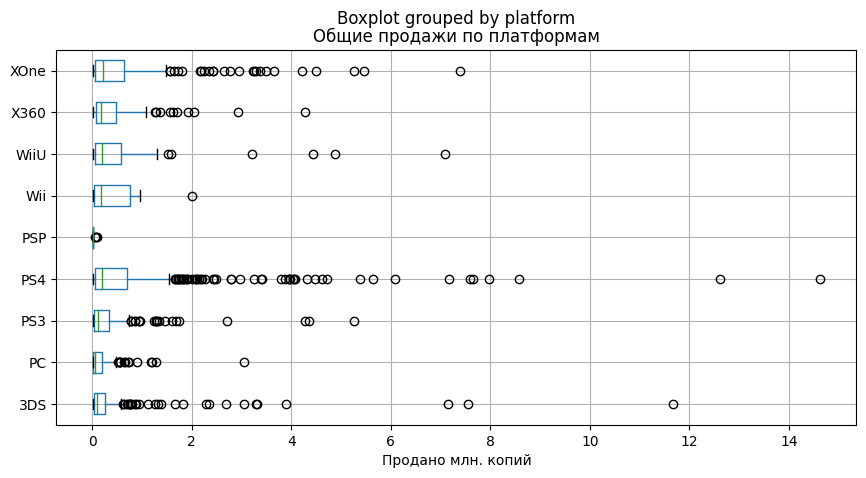

In [50]:
top9 = df['platform'].value_counts().head(9)
df.query('platform in @top9.index').boxplot(by='platform', column='total_sales', figsize=(10, 5), vert=False)
plt.title('Общие продажи по платформам')
plt.xlabel('Продано млн. копий')
plt.show();

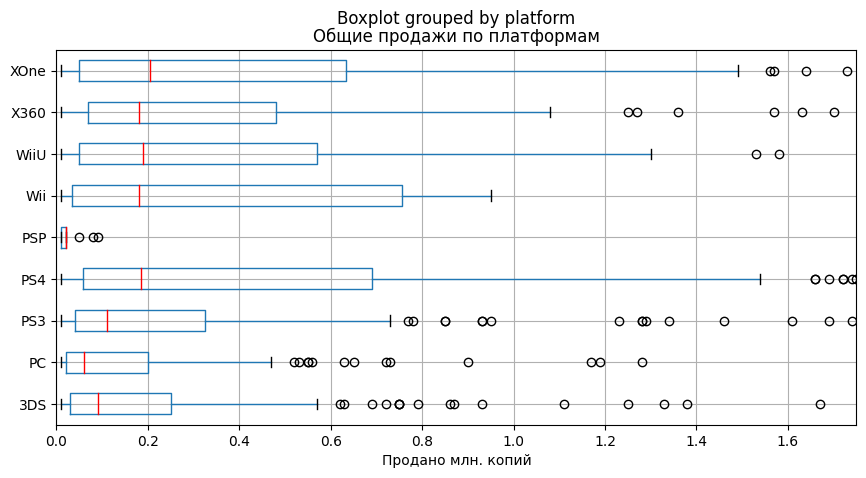

In [51]:
(df.query('platform in @top9.index')
     .boxplot(by='platform', column='total_sales', figsize=(10, 5), vert=False, medianprops=dict(color='red')))
plt.xlim(0, 1.75) 
plt.title('Общие продажи по платформам')
plt.xlabel('Продано млн. копий')
plt.show();

In [52]:
df.query('platform in @top9.index').groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,212.0,0.408868,1.188368,0.01,0.0300,0.090,0.2500,11.68
PC,152.0,0.178026,0.328553,0.01,0.0200,0.060,0.2000,3.05
PS3,219.0,0.311324,0.633059,0.01,0.0400,0.110,0.3250,5.27
PS4,376.0,0.766356,1.614969,0.01,0.0575,0.185,0.6900,14.63
PSP,13.0,0.027692,0.027735,0.01,0.0100,0.020,0.0200,0.09
Wii,11.0,0.460909,0.625451,0.01,0.0350,0.180,0.7550,2.01
WiiU,73.0,0.588767,1.161467,0.01,0.0500,0.190,0.5700,7.09
X360,113.0,0.430088,0.624532,0.01,0.0700,0.180,0.4800,4.28
XOne,228.0,0.615614,1.046513,0.01,0.0500,0.205,0.6325,7.39


После определения актуального периода платформ осталось 9. Выдающиеся выбросы на боксплоте означают наиболее выдающиеся по продажам тайтлы. По границам ящика, отметкам медианы и плотности точек можно определить характерные, средние и выдающиеся продажи для каждой платформы. Более подробно опишу это в финальном выводе.

Поставлена задача определить как влияют на продажи отзывы пользователей и критиков. Выберу некоторые наиболее актуальные платформы.

Коэффициент корреляции PS3: 0.447
Коэффициент корреляции PS4: 0.403
Коэффициент корреляции X360: 0.515
Коэффициент корреляции XOne: 0.429
Коэффициент корреляции PC: 0.169


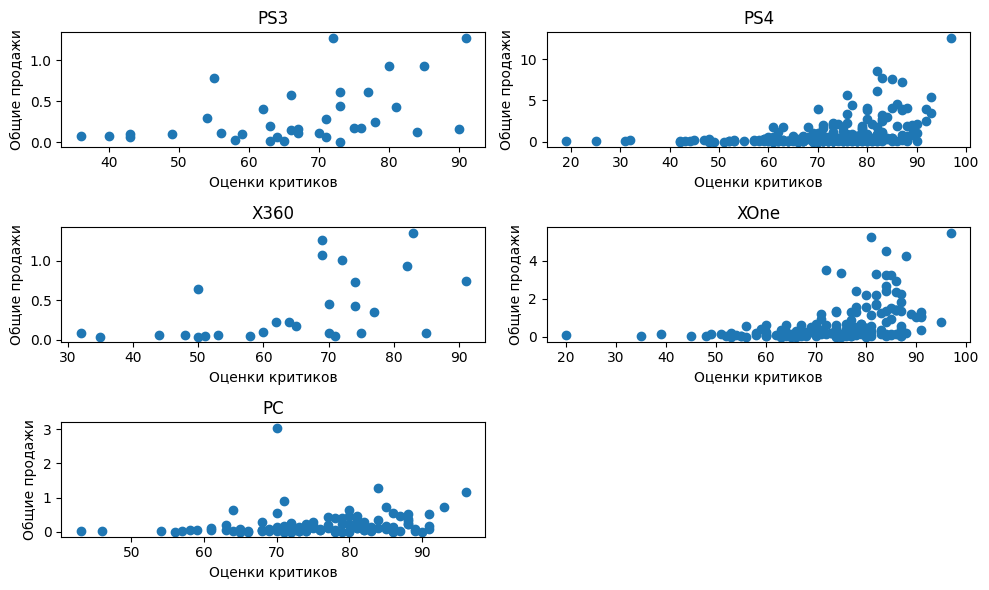

In [82]:
platforms = ['PS3', 'PS4', 'X360', 'XOne', 'PC']
fig, axs = plt.subplots(3, 2, figsize=(10, 6))
for i, platform in enumerate(platforms[:5]): 
    row = i // 2
    col = i % 2
    platform_data = df[df['platform'] == platform]
    axs[row, col].scatter(platform_data['critic_score'], platform_data['total_sales'])
    axs[row, col].set_title(platform)
    axs[row, col].set_xlabel('Оценки критиков')
    axs[row, col].set_ylabel('Общие продажи')
    print(f'Коэффициент корреляции {platform}: {platform_data["critic_score"].corr(platform_data["total_sales"]):.3f}')

if len(platforms) < 6:
    fig.delaxes(axs.flatten()[len(platforms)])

plt.tight_layout()
plt.show()

Коэффициент корреляции PS3: -0.167
Коэффициент корреляции PS4: -0.040
Коэффициент корреляции X360: -0.137
Коэффициент корреляции XOne: -0.070
Коэффициент корреляции PC: -0.076


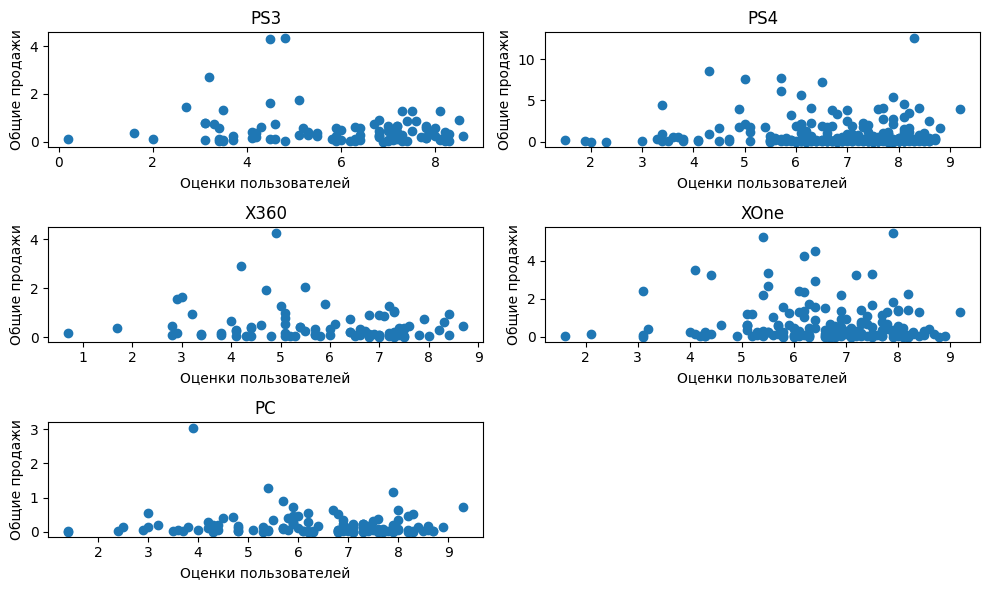

In [84]:
fig, axs = plt.subplots(3, 2, figsize=(10, 6))
for i, platform in enumerate(platforms[:5]): 
    row = i // 2
    col = i % 2
    platform_data = df[df['platform'] == platform]
    axs[row, col].scatter(platform_data['user_score'], platform_data['total_sales'])
    axs[row, col].set_title(platform)
    axs[row, col].set_xlabel('Оценки пользователей')
    axs[row, col].set_ylabel('Общие продажи')
    print(f'Коэффициент корреляции {platform}: {platform_data["user_score"].corr(platform_data["total_sales"]):.3f}')

if len(platforms) < 6:
    fig.delaxes(axs.flatten()[len(platforms)])

plt.tight_layout()
plt.show()

В целом можно сказать, что зависимость продаж от оценок пользователей и критиков слабая либо средняя. Подробно опишу в финальном выводе.<br><br>
Поставлена задача выделить самые прибыльные жанры. Определить жанры с высокими и низкими продажами.

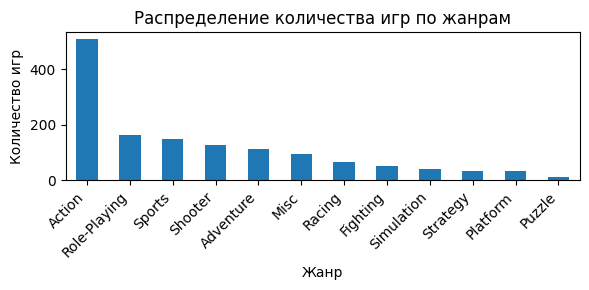

In [88]:
genre_counts = df['genre'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(6, 3))
genre_counts.plot(kind='bar')
plt.title('Распределение количества игр по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Количество игр')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

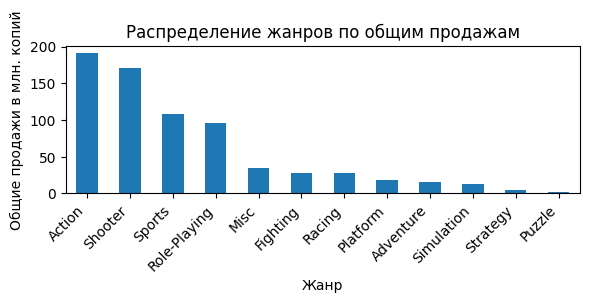

In [89]:
genre_sales = df.groupby('genre')['total_sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(6, 3))
genre_sales.plot(kind='bar')
plt.title('Распределение жанров по общим продажам')
plt.xlabel('Жанр')
plt.ylabel('Общие продажи в млн. копий')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

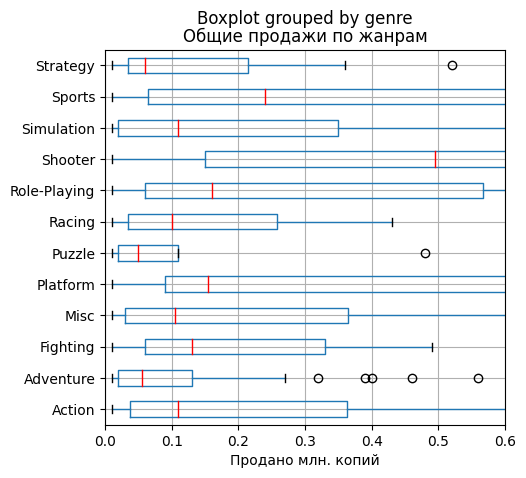

In [94]:
df.boxplot(by='genre', column='total_sales', figsize=(5, 5), vert=False, medianprops=dict(color='red'))
plt.xlim(0, .6) 
plt.title('Общие продажи по жанрам')
plt.xlabel('Продано млн. копий')
plt.show();

Наиболее прибыльные жанры можно определить по боксплоту. Те, у которых медиана выше остальных, в среднем лучше продаются. Таковыми являются shooter и sports. Ниже всего медианное значение у puzzle, strategy и adventure.

### Шаг 4. Портрет пользователя каждого региона

In [106]:
def region_info(region):
    top_platforms = (df.groupby('platform')[region].sum()).sort_values(ascending=False).head(5)
    top_genres = (df.groupby('genre')[region].sum()).sort_values(ascending=False).head(5)
    rating_sales = df.groupby('rating')[region].mean().sort_values(ascending=False)
    print('Топ 5 платформ:')
    print(top_platforms)
    print()
    print('Топ 5 жанров:')
    print(top_genres)
    print()
    print('Средние продажи по категориям рейтинга ESRB:')
    print(rating_sales)

Помня про то, что в столбце с рейтингом ESRB находится 6,8к пропущенных значений, а применяется он главным образом для игр, реализуемых в США и Канаде, то для того, чтоб не упустить эти строки при анализе отдельных регионов, заменю NaN на строковое Unknown.

In [107]:
df['rating'].fillna('unknown', inplace=True)
region_info('na_sales')

Топ 5 платформ:
platform
PS4     98.61
XOne    81.27
X360    28.50
3DS     22.64
PS3     22.05
Name: na_sales, dtype: float64

Топ 5 жанров:
genre
Shooter         78.70
Action          71.92
Sports          45.96
Role-Playing    32.90
Misc            14.61
Name: na_sales, dtype: float64

Средние продажи по категориям рейтинга ESRB:
rating
M          0.387166
E          0.238491
E10+       0.189540
T          0.168377
unknown    0.119516
Name: na_sales, dtype: float64


In [108]:
region_info('eu_sales')

Топ 5 платформ:
platform
PS4     130.04
XOne     46.25
PS3      25.54
PC       17.98
3DS      16.12
Name: eu_sales, dtype: float64

Топ 5 жанров:
genre
Action          73.31
Shooter         65.39
Sports          45.32
Role-Playing    27.67
Racing          14.12
Name: eu_sales, dtype: float64

Средние продажи по категориям рейтинга ESRB:
rating
M          0.376032
E          0.271981
T          0.147018
E10+       0.144540
unknown    0.108194
Name: eu_sales, dtype: float64


In [109]:
region_info('jp_sales')

Топ 5 платформ:
platform
3DS     44.24
PS4     15.02
PS3     11.22
WiiU     7.31
PSP      0.36
Name: jp_sales, dtype: float64

Топ 5 жанров:
genre
Role-Playing    26.47
Action          24.68
Fighting         5.91
Shooter          4.86
Misc             3.76
Name: jp_sales, dtype: float64

Средние продажи по категориям рейтинга ESRB:
rating
unknown    0.088603
T          0.047061
E          0.041934
M          0.029190
E10+       0.024023
Name: jp_sales, dtype: float64


В целом по статистике видно, что японский пользователь несколько отличается от европейского и американского. Подробное описание будет в финальном выводе.

### Шаг 5. Проверка гипотез

**Гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.**<br>
В данном случае не поставлена задача проверить в большую или меньшую сторону будет различие, если оно будет, поэтому гипотезы сформулированы так:<br>
Н0: cредние пользовательские рейтинги платформ Xbox One и PC равны.<br>
Н1: средние пользовательские рейтинги платформ Xbox One и PC различаются.<br><br>
Сформирую две выборки.

In [112]:
xone_series = df[df['platform'] == 'XOne']['user_score'].dropna()
pc_series = df[df['platform'] == 'PC']['user_score'].dropna()

Для того, чтоб проверить их дисперсии, проведу тест Левене.

In [113]:
statistic, p_value = levene(xone_series, pc_series)
print("Statistic:", statistic)
print("p-value:", p_value)
if p_value > 0.05:
    print("Не удалось отвергнуть нулевую гипотезу: дисперсии равны.")
else:
    print("Отвергаем нулевую гипотезу: дисперсии различаются.")

Statistic: 6.068902241960325
p-value: 0.014346996415584392
Отвергаем нулевую гипотезу: дисперсии различаются.


In [114]:
alpha = 0.005
results = st.ttest_ind(xone_series, pc_series, equal_var=False)
print(f'p-value: {results.pvalue:.3f}')
if results.pvalue < alpha:
    
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
    
print()
print(f'Среднее первой выборки: {xone_series.mean()}')
print(f'Среднее второй выборки: {pc_series.mean()}')

p-value: 0.135
Нет оснований отвергнуть нулевую гипотезу

Среднее первой выборки: 6.594545454545456
Среднее второй выборки: 6.313821138211383


P-value указывает на то, что вероятность получить равные средние выборочные составляет примерно 13,5%. На основании этого нулевая гипотеза о равенстве рейтингов признаётся верной.<br><br>
**Гипотеза: средние пользовательские рейтинги жанров Action и Sports разные.**<br>
Н0: cредние пользовательские рейтинги жанров Action и Sports равны.<br>
Н1: средние пользовательские рейтинги жанров Action и Sports различаются.

In [115]:
action_series = df[df['genre'] == 'Action']['user_score'].dropna()
sports_series = df[df['genre'] == 'Sports']['user_score'].dropna()

In [116]:
statistic, p_value = levene(action_series, sports_series)
print("Statistic:", statistic)
print("p-value:", p_value)
if p_value > 0.05:
    print("Не удалось отвергнуть нулевую гипотезу: дисперсии равны.")
else:
    print("Отвергаем нулевую гипотезу: дисперсии различаются.")

Statistic: 19.348758145863272
p-value: 1.4049365654049049e-05
Отвергаем нулевую гипотезу: дисперсии различаются.


In [117]:
alpha = 0.005
results = st.ttest_ind(action_series, sports_series, equal_var=False)
print(f'p-value: {results.pvalue:.30f}')
if results.pvalue < alpha:
    
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
    
print()
print(f'Среднее первой выборки: {action_series.mean()}')
print(f'Среднее второй выборки: {sports_series.mean()}')

p-value: 0.000000000000079316776252382222
Отвергаем нулевую гипотезу

Среднее первой выборки: 6.689629629629629
Среднее второй выборки: 5.199193548387096


P-value указывает на то, что вероятность получить равные средние крайне мала. На основании этого нулевая гипотеза отвергается в пользу альтернативной.

### Шаг 6. Общий вывод

В ходе исследования были выявлены следующие проблемы в данных:
- Пропущенные значения в дате релиза наименований. Пропуски были заполнены соответствуюшими значениями при помощи нейросети, выдача которой контролировалась вручную.
- Множественные пропущенные значения в оценках критиков и пользователей были оставлены без корректировки ввиду их большого объёма и невозможности достоверного заполнения каким-либо из усредняющих способов.
- Пропуски классификатора ESRB были скорректированы маркером unknown, для учёта соответствующих строк при анализе региональных особенностей. <br>

Предположительно, часть пропусков возникла в результате ошибок выгрузки из базы данных, другая в результате недостатка данных при сборе информации.

#### Цели исследовательского анализа:
1. Определение платформ с наибольшими суммарными продажами. Определение характерного срока жизни платформы.
2. Определение актуального временного периода для исследования.
3. Определение лидирующих по продажам платформ. Определение потенциально прибыльных платформ.
4. Анализ глобальных продаж по платформам.
5. Определение влияния оценок пользователей и критиков на продажи.
6. Определение наиболее прибыльных жанров.

1. Первая пятёрка платформ по суммарным продажам за всё наблюдаемое время выглядит следующим образом: 
- PS2 (2161 млн. копий)
- DS (2151 млн. копий)
- PS3 (1331 млн. копий)
- Wii (1320 млн. копий)
- X360 (1261 млн. копий)

Средний срок жизни платформы составляет 8-9 лет. По факту мы имеем лидеров рынка Playstation и XBOX, чьи поколения консолей живут 10-12 лет и всех остальных, чья продолжительность жизни 5-9 лет. В основном это консоли Nintendo, чья популярность во многом ограничена японским регионом, но в то же время этот регион имеет большой объём рынка. Характерный срок набора популярности 3-5 лет, после чего в течение также 3-5 лет происходит спад.<br><br>
Из интересных особенностей можно выделить платформу PS2, которая в период 2003-2007 находилась на плато популярности. А также мобильные игровые платформы, графики распределения которых могут иметь несколько пиков либо стартовать сразу с высоких продаж, что говорит о более высокой подверженности влиянию маркетинговых кампаний, так как мобильные платформы рассчитаны на более молодого пользователя.<br><br>
Особняком стоит платформа PC, игры на которую выпускаются и продаются в течение всего наблюдаемого периода. Количество выпускаемых на PC игр росло в период 1995-2011, после чего произошёл спад, связать который можно со всё более увеличивающейся популярностью игровых консолей в целом. В целом PC остаётся актуальной платформой в любом временном периоде, график продаж показывает, что они остаются стабильно прогнозируемыми, хоть и в целом более низкими, чем на консолях.<br><br>
2. Актуальным временным периодом для исследования был выбран промежуток 2014-2016 гг, с учётом особенностей изменения трендов в отрасли.<br><br>
3. Лидирующими по продажам платформами в актуальном периоде являются:
- PS4 (288.15 млн. копий)
- XOne (140.36 млн. копий)
- 3DS (86.68 млн. копий)
- PS3 (68.18 млн. копий)
- X360 (48.60 млн. копий)
- PC (27.06 млн. копий)

Стоит отметить, что к 2016 г. платформы PS3, X360 и 3DS уже завершают свой жизненный цикл в связи с обновлением поколения, поэтому как потенциально прибыльные следует выбирать те, у которых только начинается рост популярности. Однозначный лидер в этом плане  - PS4, следом идёт XOne. Будет сохранять свою актуальность и PC.<br><br>
4. Визуализация распределения продаж по наиболее актуальным платформам показывает следующую структуру:
- PS4. 50% продаж находятся в диапазоне 0,06 - 0,7 млн.копий. Медиана - 0,19 млн.копий. Выдающиеся продажи: 1,48 - 6,6 млн.копий. Исключительные продажи: 6 - 15 млн.копий.
- XOne. 50% продаж находятся в диапазоне 0,05 - 0,63 млн.копий. Медиана - 0,2 млн.копий. Выдающиеся продажи: 1,5 - 4 млн.копий. Исключительные продажи: 4 - 7,9 млн.копий.
- PC. 50% продаж находятся в диапазоне 0,02 - 0,2 млн.копий. Медиана - 0,06 млн.копий. Выдающиеся продажи: 0,44 - 0,75 млн.копий. Исключительные продажи: 0,75 - 1,8 млн.копий. <br><br>


5. В целом можно сказать, что зависимость продаж от оценок пользователей и критиков слабая. Более всего она выражена на PS и XBox, где продажи и оценки критиков коррелируют с коэффициентом 0,4 - 0,5. Корреляция с оценками на PC не выражена и составляет 0,17. В случае с оценками пользователей корреляция близка к нулю и коэффициент принимает отрицательные значения. Из этого можно сделать вывод, что на количество продаж в первую очередь влияют другие факторы, такие как, например, успех маркетинговой компании. <br>


6. Наиболее продающимися жанрами являются:
- Shooter (медиана - 0,49 млн. копий)
- Sports (медиана - 0,23 млн. копий)
<br><br>
Жанры, которые показывают самые низкие продажи: <br><br>
- Strategy (медиана - 0,05 млн. копий)
- Puzzle (медиана - 0,04 млн. копий)
- Adventure (медиана - 0,04 млн. копий)<br><br>
В общем случае, учитывая общую нарастающую популярность игровых консолей, лучше продаваться будут те жанры, которые ориентированы на особенности консольного гейминга, такие как, например, управление геймпадом.

#### Портрет пользователей по регионам:
1. Северная Америка.<br><br>
Игрок в основном предпочитает консоли Sony и Microsoft, присутствует на рынке и портативная 3DS. Любимые игры динамичные, остросюжетные либо спортивные. Предпочитает игры категории М, рассчитанные на взрослую аудиторию, но суммарно больше продаж совершается в категориях E, E10+, которые рассчитаны на семейное использование и подходят для возрастов 3-13 лет.<br><br>
2. Европа. <br><br>
Игрок предпочитает консоли Sony и Microsoft, более популярен PC, что говорит о том, что чаще в игры играют индивидуально. Любимые игры также динамичные, остросюжетные либо спортивные. Чаще всего покупает игры категории М, реже категорий E и E10+. Игры категории ЕС, рассчитанные на 3+ лет, невостребованы.<br><br>
3. Япония. <br><br>
Игрок предпочитает исключительно консоли Sony и Nintendo. Портативные игровые платформы популярнее стационарных. Любимый жанр - RPG и Action. Также популярен жанр Fighting. В этом регионе всплывает заглушка unknown, проставленная на место пропусков в рейтинге ESRB, что говорит о том, что регион замкнут на внутренний рынок и потребляет в основном игры, которые не попадают на продажу в NA или EU. 